# Baseline model (This task took me about 2 hours)

Since the dates in the test data are for the 15 days after the last date in the training data, I want to create a benchmark model that predicts the corresponding value 15 days before, which is a very naive model. 

I will predict the last 15 days of my available data and assess my predictions using MAPE. Afterwards, I want to make an analysis of the error, focusing on the stores and families that are being harder to predict using this simple model. Finally, I will predict the test set and submit the model to get my personal baseline.

## Remarks

The harder categories to predict are the bigger ones: GROCERY I, BEVERAGES, CLEANING, DAIRY and PRODUCE. 

I have a hunch that the smaller families might be well off with a very simple baseline model, since it will probably be very hard to obtain meaningful generalizations from them. For this reason, the next step in the modelling would be to model only the harder product families.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

import os

DATA_FOLDER = '/home/jeronimo/Desktop/Freshflow_techChallenge/store_sales_forecasting/data'

In [3]:
dtype_map = {'id':str, 'date':str, 'store_nbr':str, 'family':str,
             'sales':float, 'onpromotion':int}
train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'), dtype=dtype_map)
train.drop('id', axis=1, inplace=True)
train['date'] = pd.to_datetime(train.date, errors='coerce', format='%Y-%m-%d')

print(train.shape)
train.head()

(3000888, 5)


,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train[(train.store_nbr=='10') & (train.family=='GROCERY I')]

,date,store_nbr,family,sales,onpromotion
45,2013-01-01,10,GROCERY I,0.0,0
1827,2013-01-02,10,GROCERY I,2579.0,0
3609,2013-01-03,10,GROCERY I,1984.0,0
5391,2013-01-04,10,GROCERY I,1565.0,0
7173,2013-01-05,10,GROCERY I,2544.0,0
...,...,...,...,...,...
2992023,2017-08-11,10,GROCERY I,2349.0,44
2993805,2017-08-12,10,GROCERY I,2629.0,46
2995587,2017-08-13,10,GROCERY I,2834.0,51
2997369,2017-08-14,10,GROCERY I,2625.0,45


In [5]:
# validation set is the last 15 days of data
validation = train[train.date>=(train.date.max() - pd.DateOffset(days=15))]
validation.date.describe(datetime_is_numeric=True)

count                  28512
mean     2017-08-07 12:00:00
min      2017-07-31 00:00:00
25%      2017-08-03 18:00:00
50%      2017-08-07 12:00:00
75%      2017-08-11 06:00:00
max      2017-08-15 00:00:00
Name: date, dtype: object

In [6]:
validation.date.max()-validation.date.min()

Timedelta('15 days 00:00:00')

In [7]:
sub_train = train[(train.date>=(pd.to_datetime('2017-07-01')))]
sub_train.shape

(81972, 5)

In [15]:
sub_train.date.describe(datetime_is_numeric=True)

count                            81972
mean     2017-07-23 12:00:00.000000256
min                2017-07-01 00:00:00
25%                2017-07-12 00:00:00
50%                2017-07-23 12:00:00
75%                2017-08-04 00:00:00
max                2017-08-15 00:00:00
Name: date, dtype: object

In [144]:
def benchmark_group_pred(store_family_group):
    store_family_group.set_index('date', inplace=True)

    store_family_group['pred'] = store_family_group.sales.shift(14)
    store_family_group['pred_date'] = store_family_group.index - pd.DateOffset(days=14)

    store_family_group.dropna(subset=['pred'], inplace=True)
    
    return store_family_group

In [145]:
pred_data = sub_train.groupby(['store_nbr', 'family'], as_index=False).apply(lambda x: benchmark_group_pred(x))
pred_data = pred_data.reset_index().drop('level_0', axis=1)
pred_data.head()

,date,store_nbr,family,sales,onpromotion,pred,pred_date
0,2017-06-15,1,AUTOMOTIVE,3.0,0,6.0,2017-06-01
1,2017-06-16,1,AUTOMOTIVE,4.0,0,19.0,2017-06-02
2,2017-06-17,1,AUTOMOTIVE,3.0,0,8.0,2017-06-03
3,2017-06-18,1,AUTOMOTIVE,2.0,0,0.0,2017-06-04
4,2017-06-19,1,AUTOMOTIVE,3.0,0,6.0,2017-06-05


In [146]:
pred_data = pd.merge(validation, pred_data[['date', 'family', 'store_nbr', 'pred', 'pred_date']],
                     on=['date', 'family', 'store_nbr'])
pred_data.head()

,date,store_nbr,family,sales,onpromotion,pred,pred_date
0,2017-07-31,1,AUTOMOTIVE,8.0,0,2.0,2017-07-17
1,2017-07-31,1,BABY CARE,0.0,0,0.0,2017-07-17
2,2017-07-31,1,BEAUTY,3.0,0,5.0,2017-07-17
3,2017-07-31,1,BEVERAGES,2414.0,24,2381.0,2017-07-17
4,2017-07-31,1,BOOKS,1.0,0,1.0,2017-07-17


$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$

In [147]:
def RMSLE(y, yhat):
    metric = (np.log(1+yhat) - np.log(1+y))**2
    return np.sqrt(metric.mean())

In [148]:
# this is overall error
RMSLE(pred_data.sales, pred_data.pred)

0.6179352253565878

# Check predictions by store and family using MSE

In [149]:
errors = pred_data.groupby(['store_nbr', 'family']).apply(lambda x: np.mean((x.sales - x.pred)**2))
errors = errors.reset_index().rename({0:'error'}, axis=1)
errors.sort_values('error')

,store_nbr,family,error
400,20,BOOKS,0.000000e+00
1288,45,BABY CARE,0.000000e+00
532,24,BOOKS,0.000000e+00
1258,44,BOOKS,0.000000e+00
1255,44,BABY CARE,0.000000e+00
...,...,...,...
78,11,GROCERY I,6.536870e+06
1063,39,CLEANING,7.376562e+06
1332,46,GROCERY I,7.729591e+06
1398,48,GROCERY I,7.964764e+06


In [150]:
# biggest errors are for the families with the most sales
errors.groupby('family').error.mean().sort_values().tail()

family
DAIRY        3.183285e+04
PRODUCE      1.695819e+05
CLEANING     8.171056e+05
BEVERAGES    1.383171e+06
GROCERY I    1.626452e+06
Name: error, dtype: float64

In [151]:
# some of these very naive predictions seem pretty good
errors.groupby('family').error.mean().sort_values().head()

family
BOOKS               0.034722
BABY CARE           0.501157
HOME APPLIANCES     0.651620
HARDWARE            4.738426
BEAUTY             23.276620
Name: error, dtype: float64

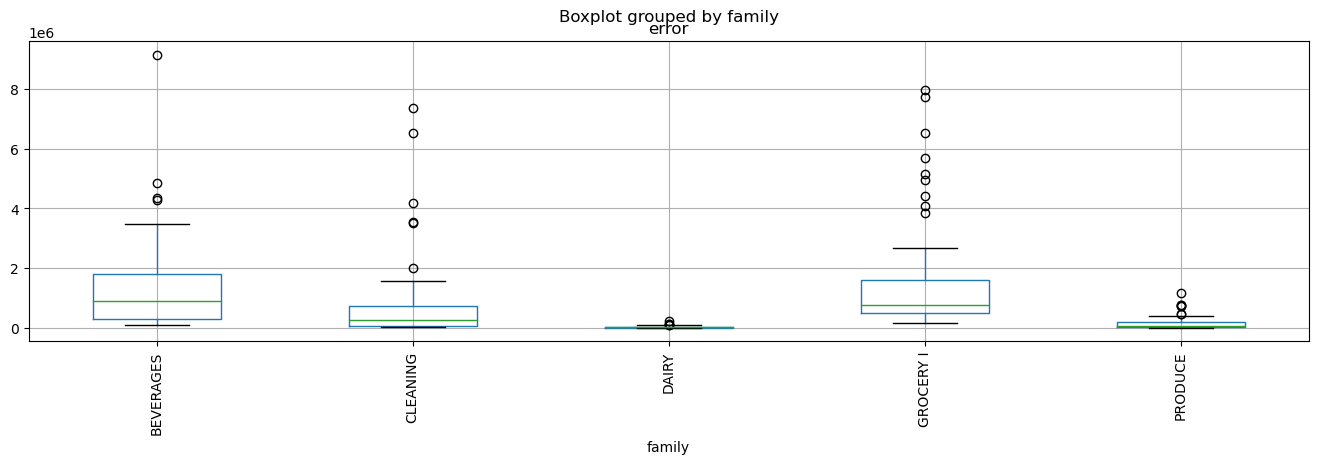

In [152]:
biggest_errorFams = ['DAIRY', 'PRODUCE', 'CLEANING', 'BEVERAGES', 'GROCERY I']
errors[errors.family.isin(biggest_errorFams)].boxplot(column='error', by='family', figsize=(16, 4))
plt.xticks(rotation=90)
plt.show()

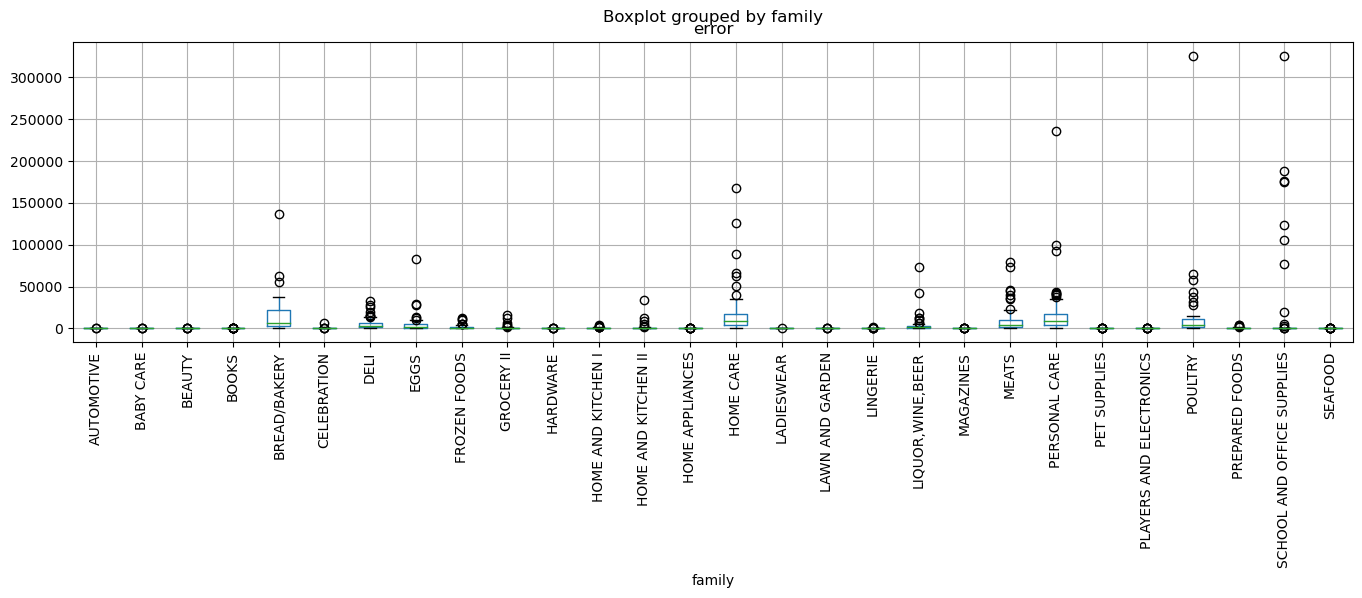

In [153]:
# this is saying that for some of the families it might be a good idea to
# use a very simple baseline model
errors[~errors.family.isin(biggest_errorFams)].boxplot(column='error', by='family', figsize=(16, 4))
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Grocery I sales')

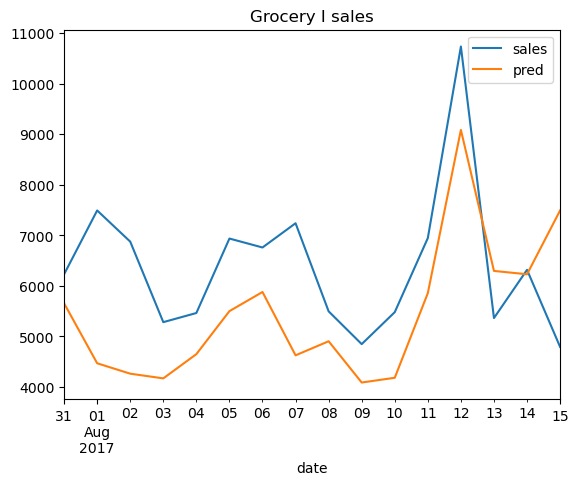

In [154]:
grocery_data = pred_data[(pred_data.family=='GROCERY I')].set_index('date')

# plot predictions for some random store
grocery_data[grocery_data.store_nbr=='40'].plot(y=['sales', 'pred'], legend=True)
plt.title('Grocery I sales')

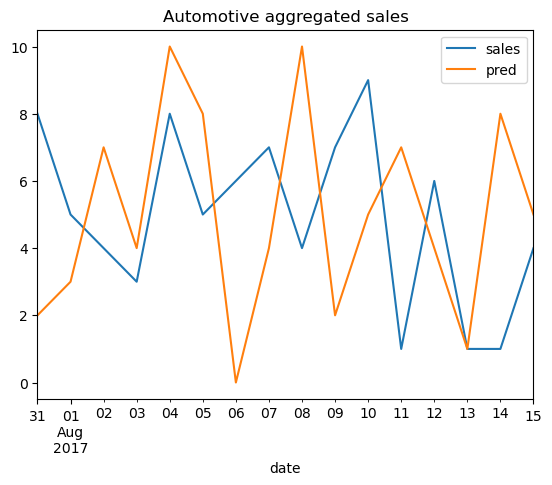

In [100]:
autom_data = pred_data[(pred_data.family=='AUTOMOTIVE')].set_index('date')

# plot predictions for some random store
autom_data[autom_data.store_nbr=='1'].plot(y=['sales', 'pred'], legend=True)
plt.title('Automotive aggregated sales')
plt.show()

In [89]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

def plot_joint_plot(verif, x='yhat', y='y', title=None, txt_coords=[20,200]): 
    """
    
    Parameters
    ---------- 
    verif : pandas.DataFrame 
    x : string 
        The variable on the x-axis
        Defaults to `yhat`, i.e. the forecast or estimated values.
    y : string 
        The variable on the y-axis
        Defaults to `y`, i.e. the observed values
    title : string 
        The title of the figure, default `None`. 

 
    Returns
    -------
    f : matplotlib Figure object
    """

    g = sns.jointplot(x=x, y=y, data = verif, kind="reg", color="0.1")
    
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]

    # ax.set_xlim([-5, None])
    # ax.set_ylim([-5, 3000])

    ax.text(txt_coords[0], txt_coords[1],
            "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,[x,y]].corr().iloc[0,1],
                                                 MAE(verif.loc[:,y].values, verif.loc[:,x].values)),
            fontsize=16)

    ax.set_xlabel("model's estimates", fontsize=15)
    
    ax.set_ylabel("observations", fontsize=15)
    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    
    return

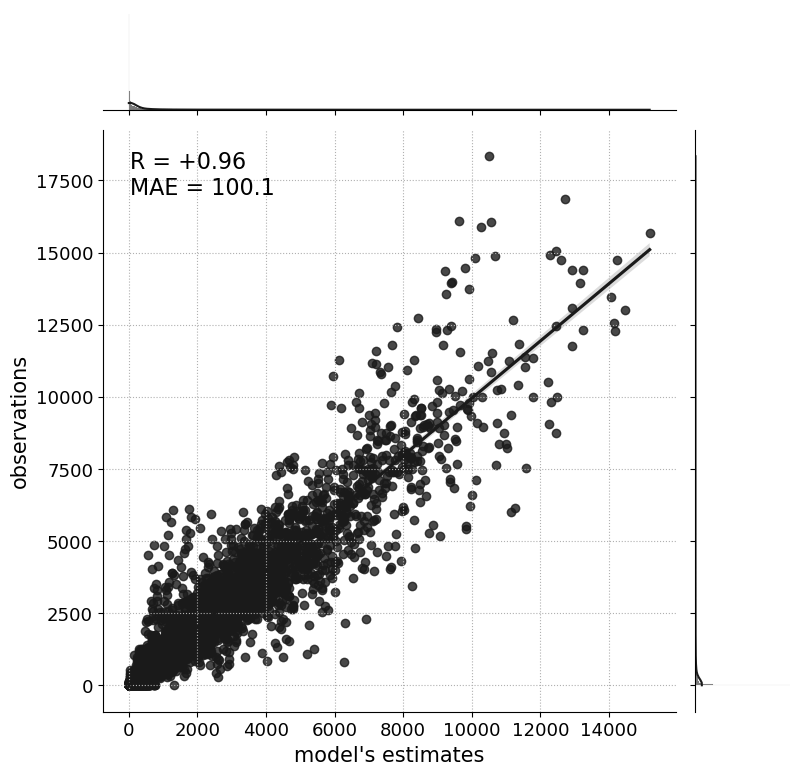

In [81]:
plot_joint_plot(pred_data, x='sales', y='pred', txt_coords=[20, 17e3])

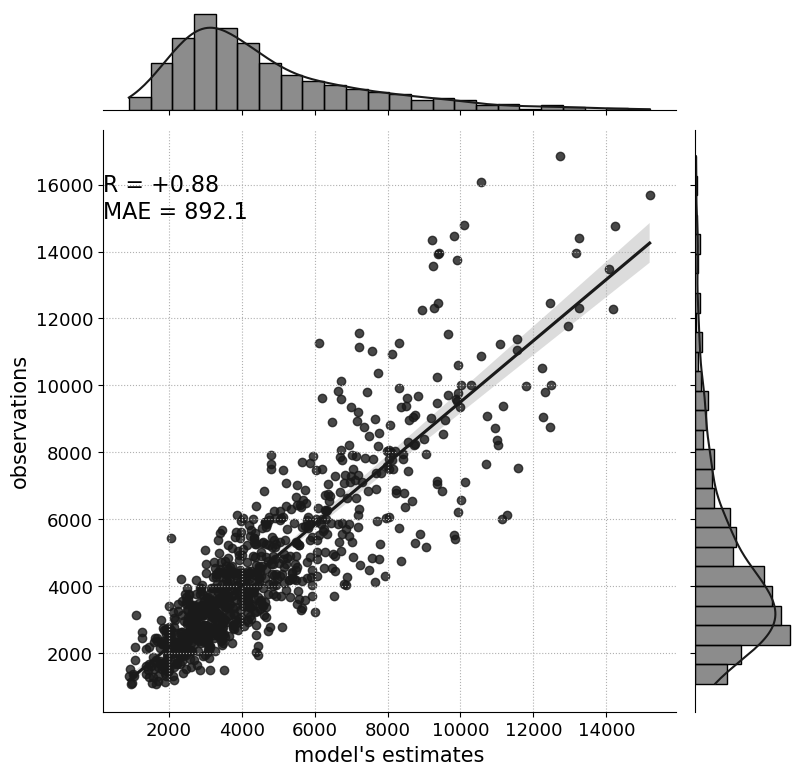

In [83]:
plot_joint_plot(grocery_data, x='sales', y='pred', txt_coords=[200, 15000])

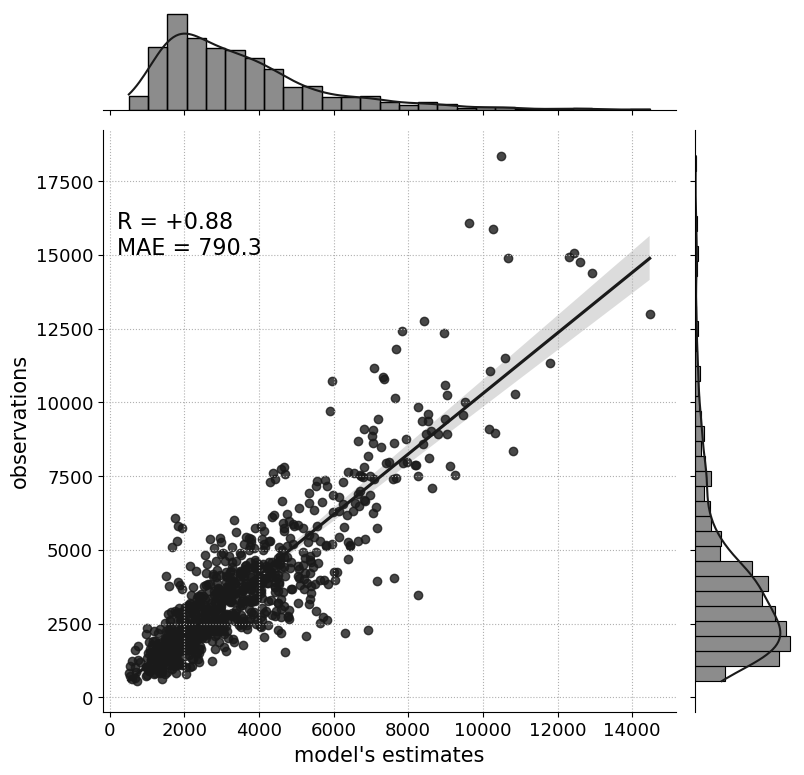

In [84]:
plot_joint_plot(pred_data[pred_data.family=='BEVERAGES'], x='sales', y='pred', txt_coords=[200, 15000])

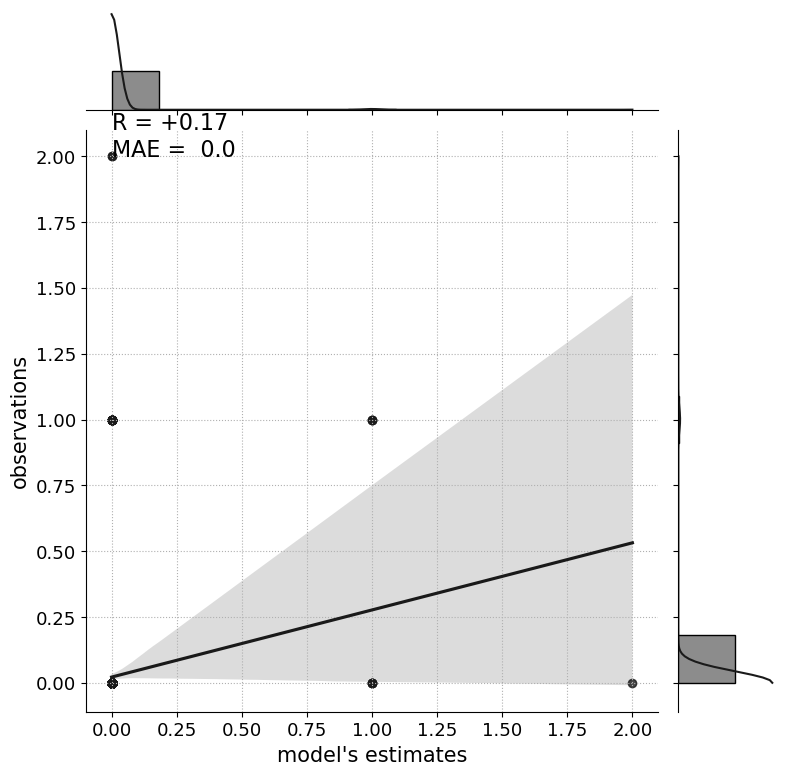

In [93]:
plot_joint_plot(pred_data[pred_data.family=='BOOKS'], x='sales', y='pred', txt_coords=[0,2])

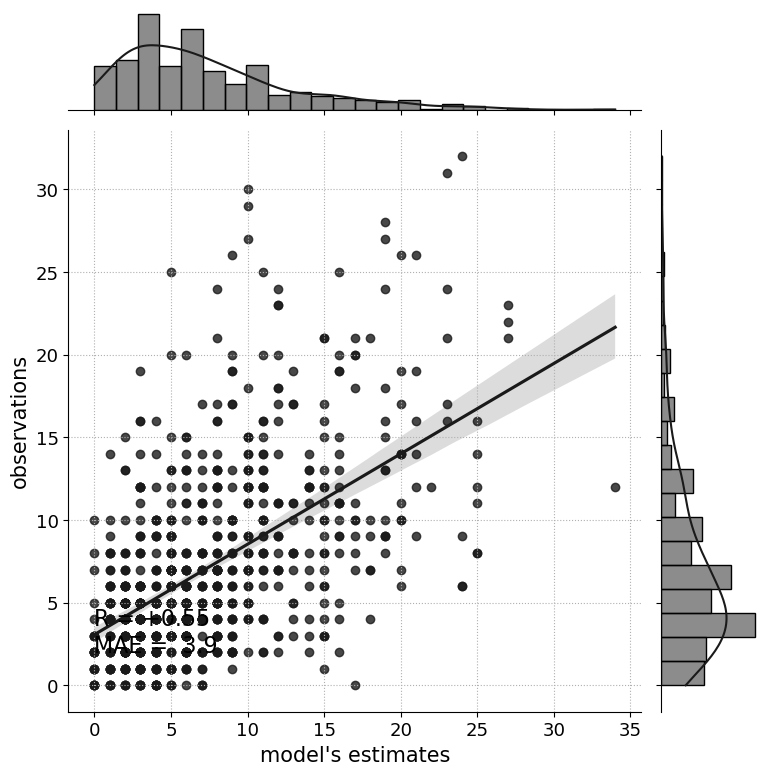

In [94]:
plot_joint_plot(pred_data[pred_data.family=='AUTOMOTIVE'], x='sales', y='pred', txt_coords=[0,2])

# Baseline model on test set

In [114]:
def benchmark_group_pred(store_family_group, offset=14):
    store_family_group.set_index('date', inplace=True)

    store_family_group['pred'] = store_family_group.sales.shift(offset)
    store_family_group['pred_date'] = store_family_group.index - pd.DateOffset(days=offset)

    store_family_group.dropna(subset=['pred'], inplace=True)
    
    return store_family_group

In [124]:
dtype_map = {'id':str, 'date':str, 'store_nbr':str, 'family':str,
             'sales':float, 'onpromotion':int}
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'), dtype=dtype_map)
# test.drop('id', axis=1, inplace=True)
test['date'] = pd.to_datetime(test.date, errors='coerce', format='%Y-%m-%d')
test['pred_date'] = test.date - pd.DateOffset(days=14)

print(test.shape)
test.head()

(28512, 6)


,id,date,store_nbr,family,onpromotion,pred_date
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017-08-02
1,3000889,2017-08-16,1,BABY CARE,0,2017-08-02
2,3000890,2017-08-16,1,BEAUTY,2,2017-08-02
3,3000891,2017-08-16,1,BEVERAGES,20,2017-08-02
4,3000892,2017-08-16,1,BOOKS,0,2017-08-02


In [125]:
sub_train = train[(train.date>=(pd.to_datetime('2017-06-01')))]

pred_data = sub_train.groupby(['store_nbr', 'family'], as_index=False).apply(lambda x: benchmark_group_pred(x, offset=14))
pred_data = pred_data.reset_index().drop(['level_0', 'pred_date'], axis=1)
pred_data.rename({'date':'pred_date'}, axis=1, inplace=True)
pred_data.head()

,pred_date,store_nbr,family,sales,onpromotion,pred
0,2017-06-15,1,AUTOMOTIVE,3.0,0,6.0
1,2017-06-16,1,AUTOMOTIVE,4.0,0,19.0
2,2017-06-17,1,AUTOMOTIVE,3.0,0,8.0
3,2017-06-18,1,AUTOMOTIVE,2.0,0,0.0
4,2017-06-19,1,AUTOMOTIVE,3.0,0,6.0


In [126]:
pred_data = pd.merge(test, pred_data[['family', 'store_nbr', 'pred', 'pred_date']],
                     on=['pred_date', 'family', 'store_nbr'], how='left')
pred_data.head()

,id,date,store_nbr,family,onpromotion,pred_date,pred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017-08-02,7.0
1,3000889,2017-08-16,1,BABY CARE,0,2017-08-02,0.0
2,3000890,2017-08-16,1,BEAUTY,2,2017-08-02,3.0
3,3000891,2017-08-16,1,BEVERAGES,20,2017-08-02,2369.0
4,3000892,2017-08-16,1,BOOKS,0,2017-08-02,0.0


In [130]:
pred_data[pred_data.pred.isnull()]

,id,date,store_nbr,family,onpromotion,pred_date,pred
24948,3025836,2017-08-30,1,AUTOMOTIVE,0,2017-08-16,NaN
24949,3025837,2017-08-30,1,BABY CARE,0,2017-08-16,NaN
24950,3025838,2017-08-30,1,BEAUTY,0,2017-08-16,NaN
24951,3025839,2017-08-30,1,BEVERAGES,35,2017-08-16,NaN
24952,3025840,2017-08-30,1,BOOKS,0,2017-08-16,NaN
...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,2017-08-17,NaN
28508,3029396,2017-08-31,9,PREPARED FOODS,0,2017-08-17,NaN
28509,3029397,2017-08-31,9,PRODUCE,1,2017-08-17,NaN
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017-08-17,NaN


In [134]:
# lets fill the null values with the mean
pred_data['pred'] = pred_data.groupby(['store_nbr', 'family']).transform(lambda x: x.fillna(x.mean())).pred

/tmp/ipykernel_42835/3771014185.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  pred_data['pred'] = pred_data.groupby(['store_nbr', 'family']).transform(lambda x: x.fillna(x.mean())).pred


In [135]:
pred_data[pred_data.pred.isnull()]

,id,date,store_nbr,family,onpromotion,pred_date,pred


I expect something in the order of 0.618

In [140]:
# and store our predictions dataframe
pred_file = os.path.join(DATA_FOLDER, 'predictions/baseline_14D.csv')
formatted_pred = pred_data[['id', 'pred']].rename({'pred':'sales'}, axis=1)
formatted_pred.to_csv(path_or_buf=pred_file, index=False)

Seems about right
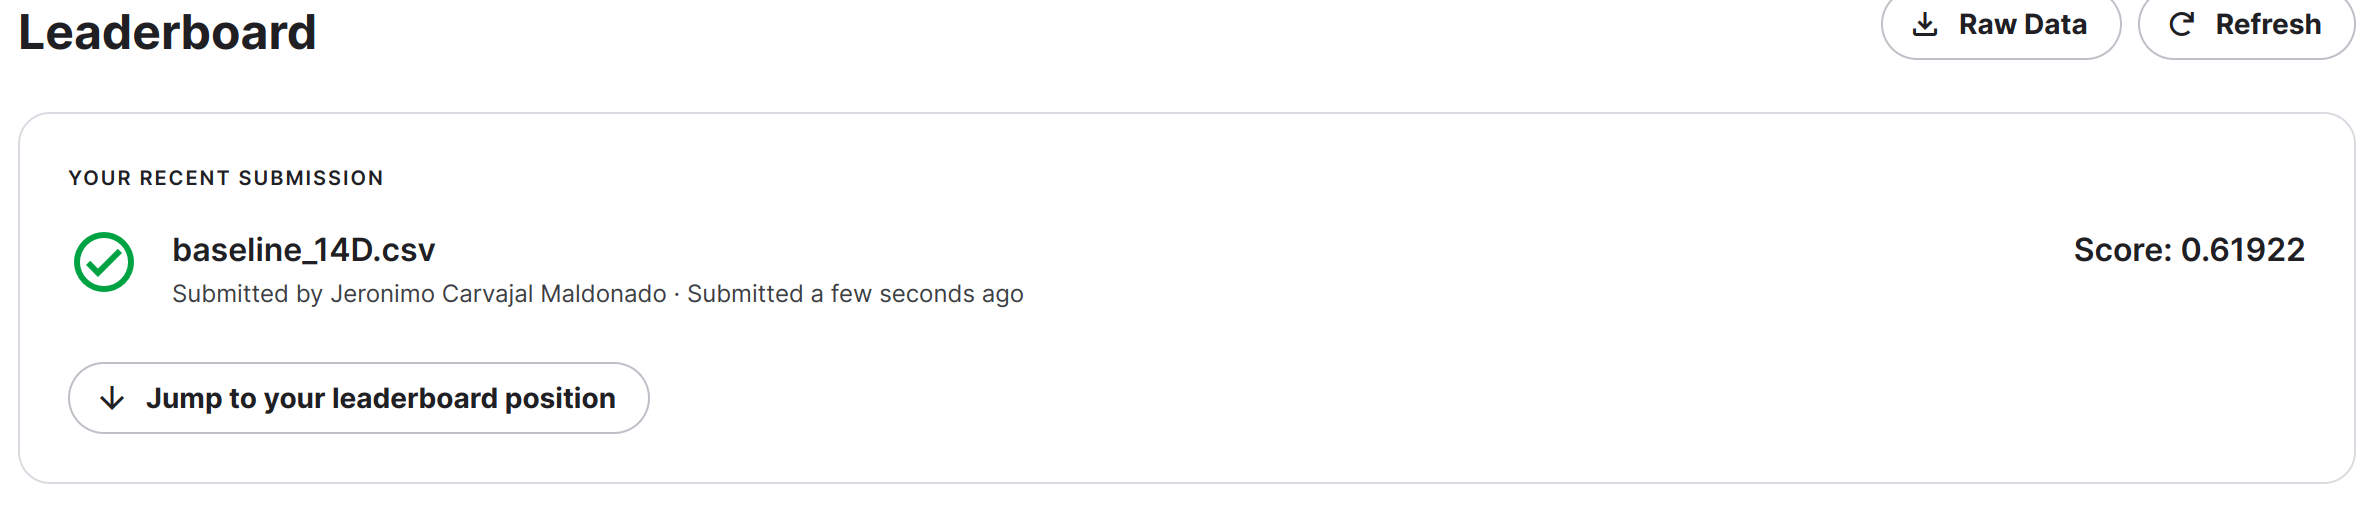

My submission granted me the 707th position from 893 people that submitted.